In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import math
import time
import os
import random
import scipy.io as sio
import tqdm
import json
import pandas as pd
import matplotlib.pyplot as plt
import json
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import dill as pickle
# fastai
# from fastai import *
# from fastai.vision import *
# from fastai.callbacks import *

from PIL import Image

In [3]:
# use the parent's path
import sys
sys.path.append("../")

In [4]:
from config import config_cls

In [5]:
config = config_cls[os.getenv('ENV', 'default')]

In [6]:
IS_IN_MASK_PIXEL_VALUE = (0, 0, 0, 255)

# Tile width / height in pixels
TILE_WIDTH_PX = 512
TILE_HEIGHT_PX = 512

In [7]:
tile_x, tile_y = 7680, 10240

# 1. 数据读取
1.1 tiles 文件meta data读取  
1.2 metadata 读取  

一张原始卫星图像被切割为若干tiles图像，每张图像默认512x512 pixel, 示例中tile_x， tile_y 定义为当前tile 在原图当中的像素级别坐标  
需要准备工具映射经纬度到像素级别坐标中（队友support）

In [8]:
datadir = config.DATA_ROOT /'raw'/ f'sentinel-2a-tile-{tile_x}x-{tile_y}y'

In [9]:
files = [file_name for file_name in (datadir / 'timeseries').glob(f'{tile_x}-{tile_y}-*.png')]
sensing_band_types = [file_name.name.split('-')[2] for file_name in files]
date_str = [
    file_name.name[len(f'{tile_x}-{tile_y}-{band}-'): -1 * len('.png')]
    for file_name, band in zip(files, sensing_band_types)]
file_info = pd.DataFrame({'IMG_FILE': files, 'SENSING_BAND': sensing_band_types, 'DATE_DT': date_str}).sort_values(['SENSING_BAND', 'DATE_DT'])
# The assumption that is all sensing band image have save date range
assert file_info.SENSING_BAND.value_counts().max() == file_info.SENSING_BAND.value_counts().min()

In [10]:
from pandas.io.json import json_normalize

metadata_files = [file for file in (datadir / 'metadata').glob(f'*.json')]
meta_dates = [file.name.split('.')[0] for file in metadata_files]
metadata = (
    json_normalize(
        [json.load(open(file, 'r')) for file in metadata_files]
        , max_level=1)
    .assign(DATE_DT=pd.to_datetime(meta_dates))
    .set_index('DATE_DT')
    .sort_index()
)

# 2. 单tile时间序列EDA

Band 不同，不同物质对光的反射情况不同，其中 B9 B10 云的占比最高。  
TCI 是RGB图像， 便于观察，在此选择TCI band 作为EDA的图像  

In [17]:
eda_imags = file_info.query('SENSING_BAND == "TCI"')

# _, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
means =[]
for row in eda_imags.itertuples():
    means.append(np.array(Image.open(row.IMG_FILE)).mean())

eda_imags = eda_imags.assign(
    MEAN=means,
    DATE_DT=pd.to_datetime(eda_imags.DATE_DT)
)

In [18]:
eda_imags = eda_imags.set_index('DATE_DT').merge(metadata['cloud-cover'], how='left', left_index=True, right_index=True)

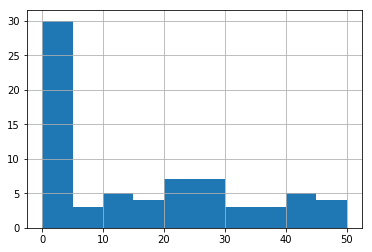

In [19]:
eda_imags['cloud-cover'].hist()

In [21]:
eda_imags[eda_imags['cloud-cover'] >45]

,IMG_FILE,SENSING_BAND,MEAN,cloud-cover
DATE_DT,,,,
2019-01-01,/Users/kevindu/Documents/workspace/ai/geo/mel-...,TCI,213.970317,46
2019-04-11,/Users/kevindu/Documents/workspace/ai/geo/mel-...,TCI,106.764294,46
2019-05-01,/Users/kevindu/Documents/workspace/ai/geo/mel-...,TCI,124.133327,50
2019-05-21,/Users/kevindu/Documents/workspace/ai/geo/mel-...,TCI,254.308353,47


In [14]:
eda_imags[['MEAN', 'cloud-cover']].corr()

,MEAN,cloud-cover
MEAN,1.000000,0.646154
cloud-cover,0.646154,1.000000


图像灰度值与云彩密度相关度非常高，因此需要去除云彩后进行判断

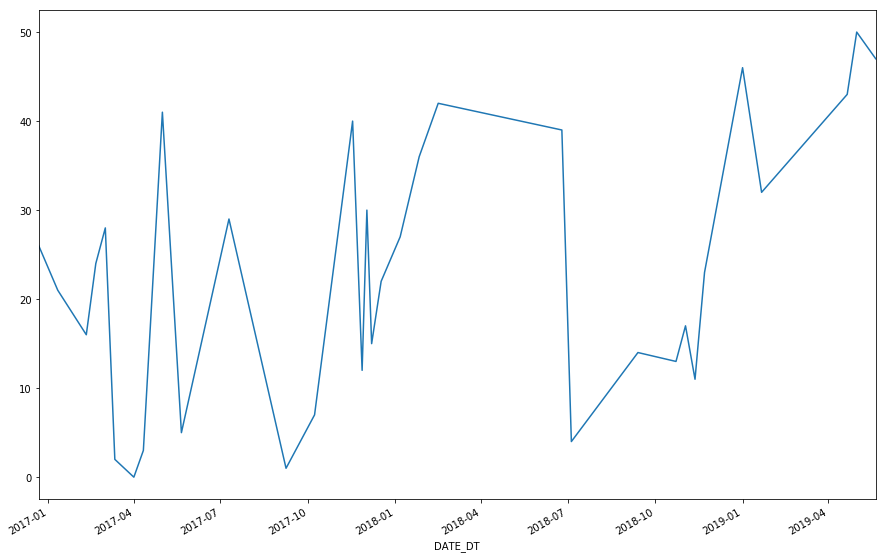

In [15]:
 _, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
metadata['cloud-cover'].drop_duplicates().plot(ax=ax)

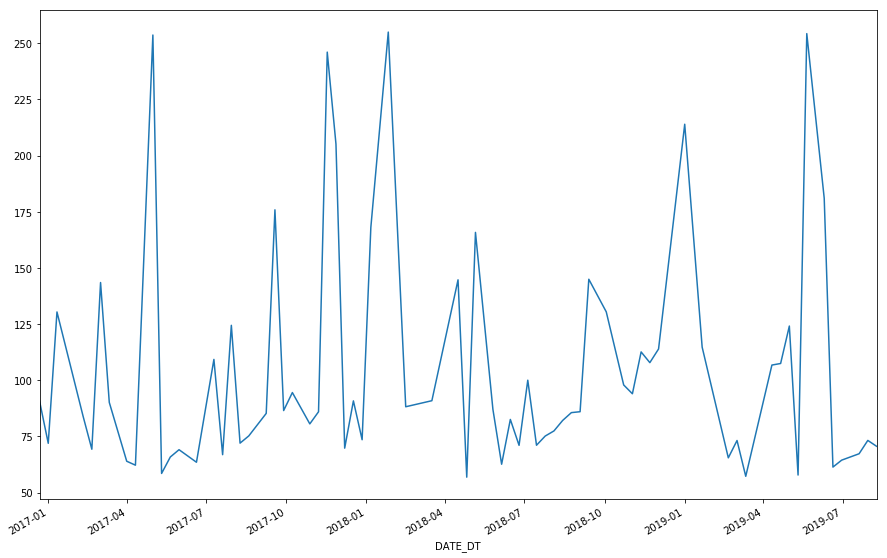

In [16]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
eda_imags['MEAN'].plot()

,MEAN,cloud-cover
MEAN,1.000000,0.646154
cloud-cover,0.646154,1.000000


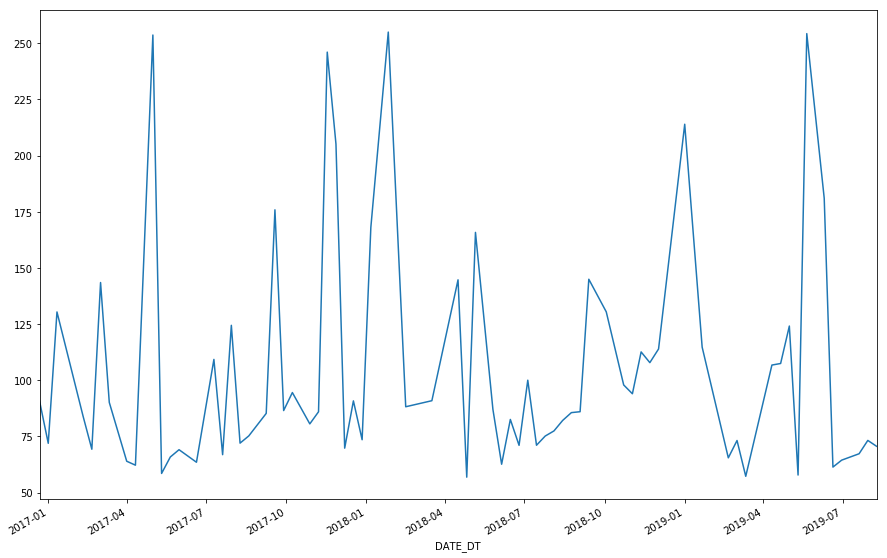